In [1]:
# default_exp capsAnalaysis

In [2]:
import sys

In [3]:
sys.path.append('/workspace/oct_ca_seg/oct/')

In [4]:
from oct.startup import *
from model import CapsNet
import numpy as np
import mlflow
from fastai.vision import *
import mlflow.pytorch as MLPY
from fastai.utils.mem import gpu_mem_get_all
from skimage import filters

In [5]:
gpu_mem_get_all()

[GPUMemory(total=16280, free=16270, used=10)]

In [6]:
cocodata_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = cocodata_path/'train/images'
valid_path = cocodata_path/'valid/images'
test_path = cocodata_path/'test/images'

In [7]:
metrics = [sens, spec, dice, my_Dice_Loss, acc]

In [8]:
runsave_dir = Path('/workspace/oct_ca_seg/runsaves/')

In [9]:
run_name = 'UNET_0001_30_' 
cfg_file = 'configUNET_APPresnet18_bs16_epochs15_lr0.001.json'

In [10]:
run_dir = runsave_dir/run_name

In [11]:
def loadConfigRun(run_dir, name):
    with open(run_dir/name, 'r') as file:
        return json.load(file)

In [12]:
cfg_dict = loadConfigRun(run_dir, cfg_file)

In [13]:
config = DeepConfig(cfg_dict)

In [14]:
cfg_dict

{'LEARNER': {'loss_alpha': 0.04,
  'loss_beta': 0.8,
  'bs': 16,
  'epochs': 30,
  'img_size': 256,
  'lr': 0.0001,
  'num_workers': 1,
  'runsave_dir': '/workspace/oct_ca_seg/runsaves/'},
 'MODEL': 'FASTAI UNET RESNET18 BACKBONE NO PRETRAIN',
 'DATSET': {'path': '/workspace/oct_ca_seg/COCOdata',
  'annotations_path': '/workspace/oct_ca_seg/COCOdata/train/images/medium_set_annotations.json'}}

## Train, Valid

In [18]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(cocodata_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_folder('train', 'valid')
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size=config.LEARNER.img_size)
data = src.databunch(cocodata_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
data.normalize(stats);
data.c_in, data.c_out = 3, 2

## Test

In [15]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(test_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images')
       .split_by_rand_pct(0.90)
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size =config.LEARNER.img_size)
data = src.databunch(test_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
#stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
stats = data.batch_stats()
data.normalize(stats);
data.c_in, data.c_out = 3, 2

## Load Model

In [ ]:
deepCap = CapsNet(config.MODEL).cuda()
learn = Learner(data = data,
                  model = deepCap,
                  metrics = metrics)

In [16]:
unet = unet_learner(data, models.resnet18, pretrained=False, metrics = metrics)

### LR finder

In [23]:
lr_find(learn)

epoch,train_loss,valid_loss,sens,spec,dice,my_Dice_Loss,acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


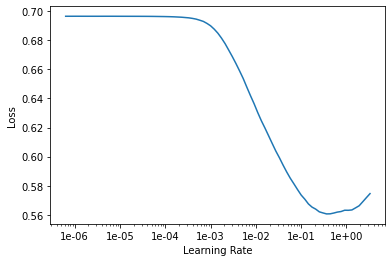

In [24]:
learn.recorder.plot()

## Run Analysis

In [17]:
unet = unet.load(run_dir/'learner')

In [18]:
class Analysis():
    def __init__(self, learner:Learner, run_dir:Path):
        self.learner = learner
        self.run_dir = run_dir
        self.metrics = pd.read_json(self.run_dir/'metrics.json')
        self.trainL =  pd.read_json(self.run_dir/'trainL.json')
        self.validL =  pd.read_json(self.run_dir/'validL.json')
    
    def remove0FromMetric(self, metric):
        zero_dict = {k:v for (k,v) in self.results[metric].items() if v==0}
        zero_dict = {k: v for k, v in sorted(zero_dict.items(), key=lambda item: item[1])}
        new_dict = {k:v for (k,v) in self.results[metric].items() if v!=0}
        new_dict = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1])}
        print('there were ', len(zero_dict.keys()), 'zeros in the ', metric,' list.')
        return zero_dict, new_dict
    
    def histPlotMetric(self, metric, save=False):
        #metric = one of 'dices', 'sens', 'specs', 'accs' 
        zeros, actual = self.remove0FromMetric(metric)
        l_actual = list(actual.values())
        l_actual = [x for x in l_actual if x==x] # get rid of nans
        mean, std, median, max, min = np.mean(l_actual), np.std(l_actual), np.median(l_actual), np.max(l_actual), np.min(l_actual)
        print(mean, std, median, max, min)
        plt.hist(l_actual)
        if save: plt.savefig(self.checkpoint_path/(metric+'.png'))
        #return l_actual
    
    def showPrediction(self, id):
        self.learner.model.eval()
        batch = self.learner.data.one_batch(ds_type=DatasetType.Valid, denorm=False, detach=True, cpu=False)
        img = self.learner.data.one_batch(ds_type=DatasetType.Valid, denorm=True, detach=True, cpu=True)[0]
        xb = batch[0][id]#.permute(1,2,0).cpu()
        yb = batch[1][id][0]#.permute(1,2,0).cpu()
        pb = self.learner.model(xb.unsqueeze(0).cuda())[0]
        #print(xb.size(), yb.size(), pb.size())
        fig, (axim, axl, axp) = plt.subplots(nrows=1, ncols=3, figsize=(16, 3.5),
                    subplot_kw={'xticks': [], 'yticks': []})
        #images
        im = axim.imshow(img[id].permute(1,2,0))
        axim.set_title('Image')
        l = axl.imshow(yb.cpu())
        axl.set_title('Label')
        p = axp.imshow(torch.argmax(pb.detach().cpu(), dim=0))
        print()
        axp.set_title('Pred')
        
        #return xb.size(), yb.size(), pb.size()

In [19]:
asis = Analysis(unet, run_dir)

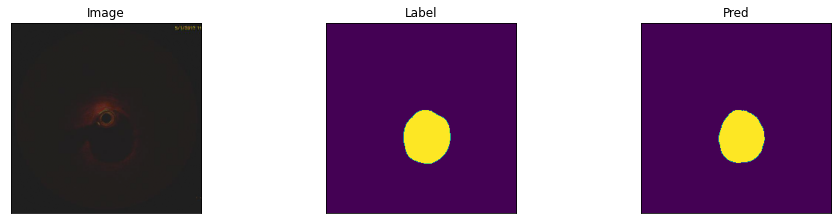

In [20]:
asis.showPrediction(0)

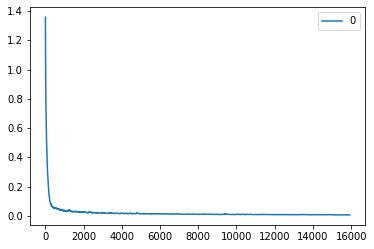

In [21]:
asis.trainL.sort_index().plot.line()

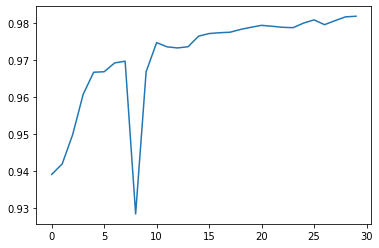

In [22]:
asis.metrics['dice'].sort_index().plot.line()

In [23]:
asis.metrics;

## test loop

In [24]:
xb,yb=data.one_batch(denorm=False,cpu=False)

In [25]:
%%time 
pb = unet.model(xb)

CPU times: user 4.83 s, sys: 299 ms, total: 5.13 s
Wall time: 928 ms


In [37]:
%%time
preds,targs = unet.get_preds()

CPU times: user 10.7 s, sys: 2.93 s, total: 13.7 s
Wall time: 11.8 s


In [38]:
preds.size(), targs.size()

(torch.Size([909, 2, 256, 256]), torch.Size([909, 1, 256, 256]))

In [58]:
preds.nelement()*preds.element_size()#/1024/1024

476577792

In [39]:
%%time
recorder = []
for p,y in iter(zip(preds,targs)): 
    p = p.unsqueeze(0)
    y = y.unsqueeze(0)
    recorder.append([met(p, y).item() for met in metrics])

CPU times: user 38min 35s, sys: 4.96 s, total: 38min 40s
Wall time: 1min 22s


In [40]:
test_results = pd.DataFrame(recorder, columns=[met.__name__ for met in unet.metrics])

In [41]:
test_results.mean(axis=0)

sens            0.943118
spec            0.996122
dice            0.968479
my_Dice_Loss    0.879996
acc             0.035721
dtype: float64

In [42]:
test_results.std(axis=0)

sens            0.080250
spec            0.006667
dice            0.054721
my_Dice_Loss    0.029703
acc             0.000000
dtype: float64

In [43]:
test_results.median(axis=0)

sens            0.961735
spec            0.997503
dice            0.980494
my_Dice_Loss    0.878303
acc             0.035721
dtype: float64

In [44]:
test_results.min(axis=0)

sens            0.355635
spec            0.928351
dice            0.524676
my_Dice_Loss    0.796850
acc             0.035721
dtype: float64

In [45]:
test_results.max(axis=0)

sens            0.984964
spec            0.999414
dice            0.992425
my_Dice_Loss    0.945599
acc             0.035721
dtype: float64

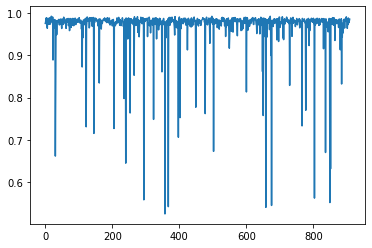

In [46]:
test_results['dice'].plot.line()

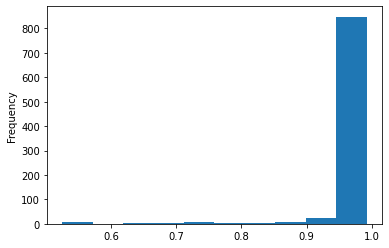

In [47]:
test_results['dice'].plot.hist()

In [35]:
test_results.to_json(run_dir/'test_results.json')

In [48]:
test_results.sort_values(by='dice')

,sens,spec,dice,my_Dice_Loss,acc
357,0.355635,0.928351,0.524676,0.802211,0.035721
658,0.370056,0.930435,0.540206,0.803789,0.035721
367,0.371611,0.963142,0.541860,0.895839,0.035721
675,0.374322,0.962208,0.544737,0.892041,0.035721
849,0.380824,0.930650,0.551589,0.800501,0.035721
...,...,...,...,...,...
707,0.982721,0.998846,0.991285,0.886085,0.035721
387,0.983247,0.999117,0.991553,0.902812,0.035721
497,0.984621,0.998712,0.992251,0.848267,0.035721
671,0.984805,0.999414,0.992344,0.924767,0.035721


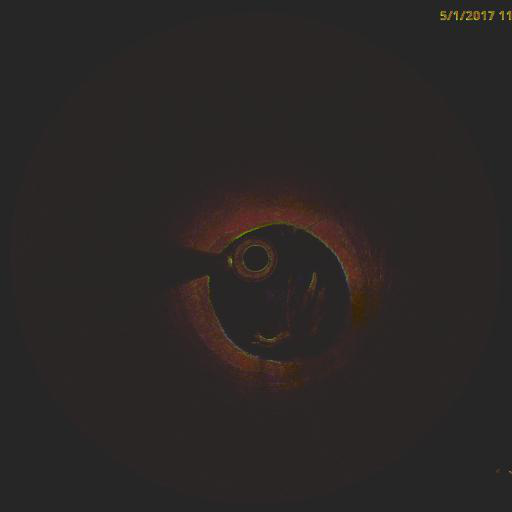

In [49]:
unet.data.valid_ds.x[11]

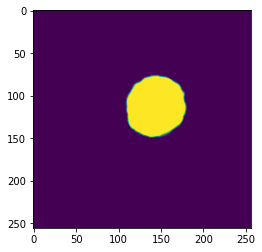

In [50]:
plt.imshow(preds[14][1])

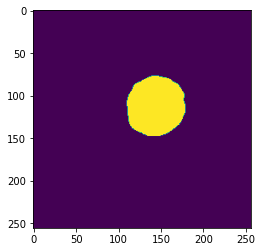

In [51]:
plt.imshow(targs[14][0])

In [166]:
learn.validate(metrics=metrics)

[0.31771377,
 tensor(0.9490),
 tensor(0.9965),
 tensor(0.9725),
 tensor(-4.5412),
 tensor(0.9404)]

In [ ]:
def freeze_to(learn, n): # freeze model up to layer n
    for i, param in enumerate(learn.model.parameters()):
        if i<n: param.requires_grad=False

In [ ]:
learn.unfreeze()

In [ ]:
freeze_to(learn, 60)

In [ ]:
for i, param in enumerate(learn.model.parameters()):
    print(i,param.requires_grad)

In [ ]:
learn.opt.clear()

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(0.00001), wd=0.01, pct_start=0.3)